# 1.1. DataFrame'yi İçeri Aktarma
---

Grubumuza verilen **logistics_shipments.csv** veri seti dosyası Kaggle üzerinden eklenmiştir ve Kaggle üzerinde 1. görevin çalışmaları yapılmıştır.

Alttaki kodda görüldüğü üzere pandas kütüphanesi import edilmiştir ve CSV dosyası okunup DataFrame oluşturulup veri setindeki ilk 5 satır ekranda gösterilmiştir.

In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/ds-beykoz/logistics_shipments.csv')
df.head()

,shipment_id,origin,destination,weight_kg,volume_m3,transport_mode,delivery_days
0,S000000000,IST,ADA,5.85,0.69,ROAD,7
1,S000000001,TRB,IST,27.21,1.79,AIR,5
2,S000000002,ADA,IZM,21.49,0.97,SEA,9
3,S000000003,IZM,ADA,3.80,2.73,AIR,3
4,S000000004,IST,ANT,26.92,0.30,SEA,3


# 1.2 Değişken Tiplerini İnceleme

---

İçeri aktarılan veri setinin içerisindeki `shipment_id`, `origin`, `destination`, `weight_kg`, `volume_m3`, `transport_mode`, `delivery_days` sütunlarının incelemesi yapılmıştır.

Yapılan incelemeler sonucu boş olan verinin olmadığı, toplam 750000 tane verinin hepsinin dolu olduğu gözlemlenmiştir. Veri setindeki 7 sütunun veri tipinin `object`, `float64` ve `int64` olduğu görülmüştür.

In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/ds-beykoz/logistics_shipments.csv')

print("\nVeri Seti İncelemeleri:")
df.info()


Veri Seti İncelemeleri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   shipment_id     750000 non-null  object 
 1   origin          750000 non-null  object 
 2   destination     750000 non-null  object 
 3   weight_kg       750000 non-null  float64
 4   volume_m3       750000 non-null  float64
 5   transport_mode  750000 non-null  object 
 6   delivery_days   750000 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 40.1+ MB


# 1.3 Eksik Değer Analizi ve Tamamlama Teknikleri Seçme
---

1.2 numaralı başlıktaki analizimizde de görüleceği üzere boş verimiz yoktur. Fakat yine de eksik verilerin analizinin yapılmasını istiyorsak ilk olarak `DataFrame` içerisindeki boş olan (`null`) verilerin toplam sayısını alıyoruz.

Ardından dokümanda da istenen grafiklerden olan `Missing Matrix` grafiğini kullanıyoruz. Bu grafikte beyaz çizgiler eksik veriyi temsil edecekti fakat şuan boş verimiz olmadığı için hiçbir çizgi görememekteyiz.

Son olarak eğer boş değer varsa bunları doldurma yöntemi ekliyoruz. 7 tane olan sütunumuzu kategorik ve sayısal olarak ayırıyoruz. Sayısal sütunları `ortalama` ile dolduruyoruz çünkü verinin merkezini bozmamaya çalışıyoruz. Kategorik verilerde ise `mod` yani en çok tekrar eden değeri alıyoruz çünkü en fazla tekrar eden değerin boş değer olma şansı daha yüksektir gibi düşünebiliriz.

Değişkenlerdeki eksik değer sayısı:
shipment_id       0
origin            0
destination       0
weight_kg         0
volume_m3         0
transport_mode    0
delivery_days     0
dtype: int64


<Figure size 1000x600 with 0 Axes>

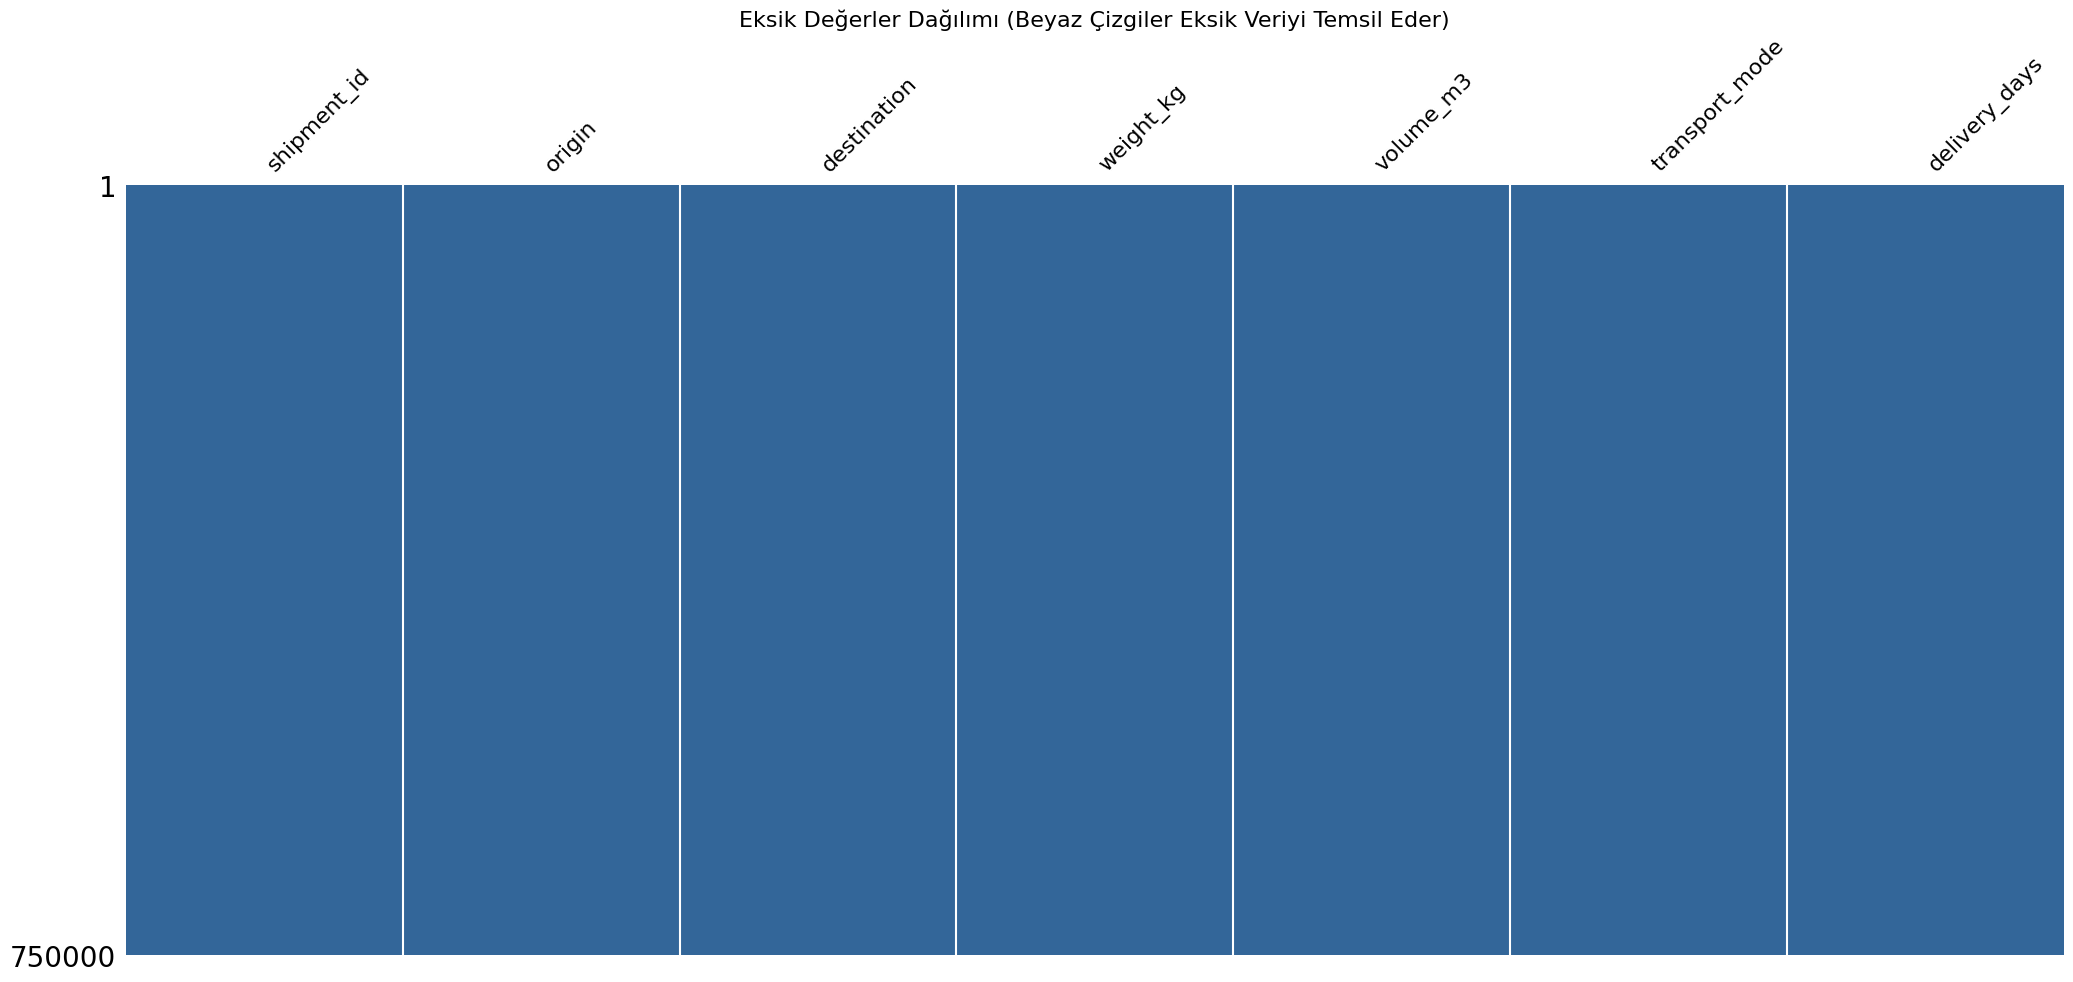


Eksik değer bulunamadı, doldurma işlemine gerek yok.


In [3]:
import missingno as msno
import matplotlib.pyplot as plt
import missingno as msno

# Eksik değerlerin sayısını gösteriyoruz
print("Değişkenlerdeki eksik değer sayısı:")
print(df.isnull().sum())

# Missing Matrix Grafiği
plt.figure(figsize=(10, 6))
msno.matrix(df, sparkline=False, color=(0.2, 0.4, 0.6))
plt.title('Eksik Değerler Dağılımı (Beyaz Çizgiler Eksik Veriyi Temsil Eder)', fontsize=16)
plt.show()

# 3. Eksik Değer Doldurma İşlemi
total_null = df.isnull().sum().sum() # Tablodaki toplam eksik sayısını buluyoruz

if total_null > 0:
    print(f"\nToplam {total_null} tane eksik değer bulundu.")
    
    # Sayısal ve Kategorik sütunları ayırıyoruz
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Sayısal sütunları ortalama ile dolduruyoruz
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    # Kategorik sütunları mod (en çok tekrarlayan) ile dolduruyoruz
    for col in cat_cols:
        # Eğer sütun tamamen boşsa hata vermemesi için kontrol
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna("Unknown")
    
    print("Tüm eksik değerler dolduruldu.")
    print("İşlem sonrası toplam eksik sayısı:", df.isnull().sum().sum())
else:
    print("\nEksik değer bulunamadı, doldurma işlemine gerek yok.")

# 1.4 Outlier (Aykırı Değer) Tespiti
---

Veri setindeki sayısal değişkenlerin merkezini bozabilecek uç değerler (*outliers*) bu adımda incelenmiştir.

### Kullanılan Yöntemler

1.  **Görselleştirme (Boxplot):**`weight_kg` ve `volume_m3` değişkenlerindeki uç değerleri tespit etmek için **kutu grafiği** kullanılmıştır.

2.  **IQR Yöntemi ile Baskılama (Capping):** Veri kaybını önlemek amacıyla, aykırı değerleri silmek yerine **Interquartile Range (IQR)** yöntemi kullanılarak alt ve üst sınırlara **baskılama işlemi** (*winsorization/clipping*) uygulanmıştır.

**Hesaplama Formülleri:**

* **Alt Sınır:** $Q1 - (1.5 \times IQR)$
* **Üst Sınır:** $Q3 + (1.5 \times IQR)$

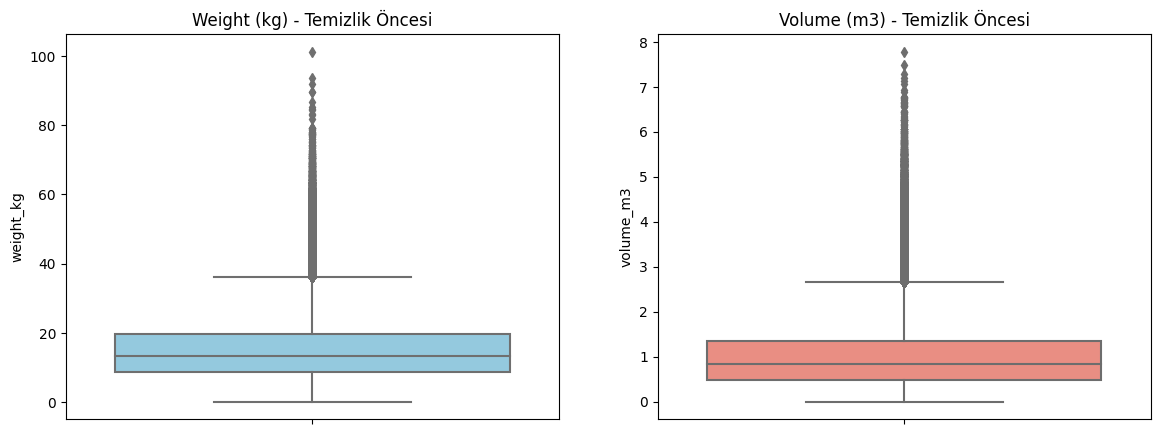

Aykırı değerler IQR sınırlarına baskılandı. Altta sonraki IQR grafiğini görebiliriz.



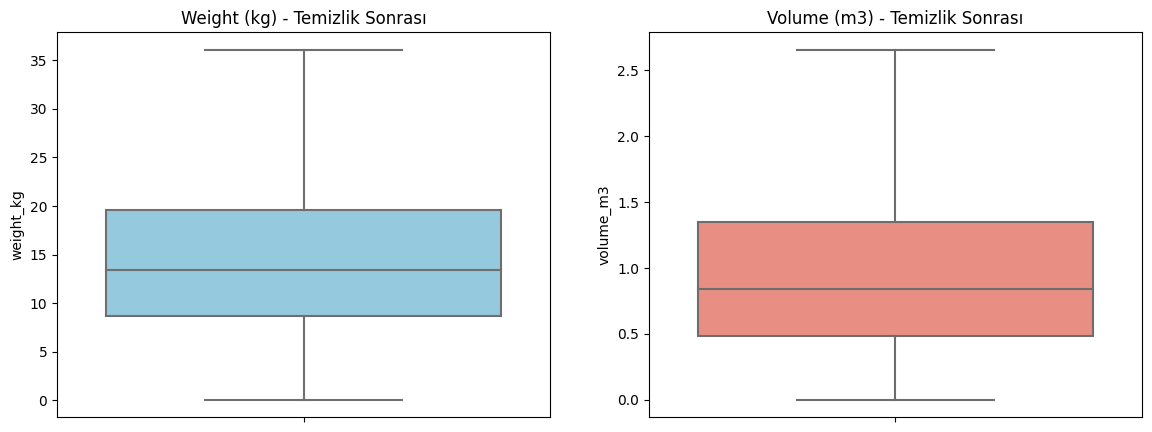

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Önceki Durumu Görselleştirme
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['weight_kg'], color='skyblue')
plt.title('Weight (kg) - Temizlik Öncesi')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['volume_m3'], color='salmon')
plt.title('Volume (m3) - Temizlik Öncesi')
plt.show()

# Outlier Handling (IQR Yöntemi ile Baskılama)
def handle_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Alt sınırdan küçükleri alt sınıra, üst sınırdan büyükleri üst sınıra eşitliyoruz
    dataframe[column] = np.clip(dataframe[column], lower_bound, upper_bound)
    return dataframe

# Fonksiyonu çalıştırıyoruz
df = handle_outliers(df, 'weight_kg')
df = handle_outliers(df, 'volume_m3')

print("Aykırı değerler IQR sınırlarına baskılandı. Altta sonraki IQR grafiğini görebiliriz.\n")

# Sonraki Durumu Görselleştirme
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['weight_kg'], color='skyblue')
plt.title('Weight (kg) - Temizlik Sonrası')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['volume_m3'], color='salmon')
plt.title('Volume (m3) - Temizlik Sonrası')
plt.show()

# 1.5 Kategorik Değişkenleri İşleme

---

### Uygulanan İşlemler:

1.  **Kimlik Değişkeninin Yönetimi (`shipment_id`):** Bu sütun silinmemiştir. Ancak bu değişken matematiksel bir şey taşımadığı için analizlere eklenmemiştir.

2.  **One-Hot Encoding:** Nominal (sıralı olmayan) kategorik değişkenler (`origin`, `destination`, `transport_mode`) için **One-Hot Dönüşümü** uygulanmıştır.
    * Bu işlem, her kategori için ayrı bir değer oluşturur (0 veya 1 değeri verilir).
    * Örneğin: `transport_mode` $\rightarrow$ `mode_AIR`, `mode_SEA`, `mode_ROAD`

* Bu işlem sonrasında, ID sütunu hariç tüm veri seti sayısal hale gelmiş ve analizlere hazır olmuştur.

İşlenecek Kategorik Değişkenler (ID Hariç): ['origin', 'destination', 'transport_mode']

Encoding Sonrası Veri Seti Boyutu: (750000, 19)
Encoding Sonrası İlk 5 Satır:


,shipment_id,weight_kg,volume_m3,delivery_days,origin_ADA,origin_ANK,origin_ANT,origin_IST,origin_IZM,origin_TRB,dest_ADA,dest_ANK,dest_ANT,dest_IST,dest_IZM,dest_TRB,mode_AIR,mode_ROAD,mode_SEA
0,S000000000,5.85,0.690,7,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
1,S000000001,27.21,1.790,5,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False
2,S000000002,21.49,0.970,9,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True
3,S000000003,3.80,2.655,3,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False
4,S000000004,26.92,0.300,3,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True


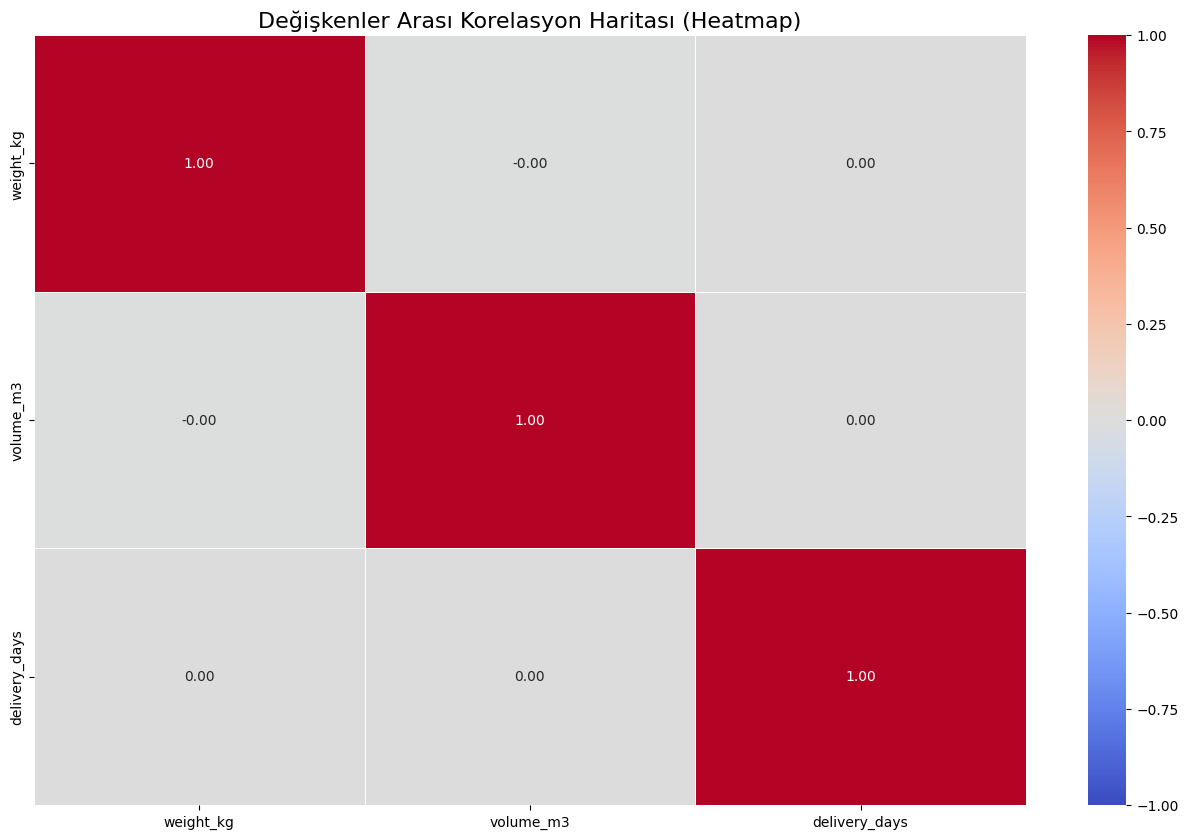

In [5]:
# Kategorik sütunları seçerken 'shipment_id' ismini listeden çıkarıyoruz.
cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col != 'shipment_id']

print(f"İşlenecek Kategorik Değişkenler (ID Hariç): {list(cat_cols)}")

# One-Hot Encoding İşlemi
# pd.get_dummies, 'columns' parametresinde belirtilmeyen sütunları (shipment_id) olduğu gibi korur.
df_encoded = pd.get_dummies(df, columns=cat_cols, prefix=['origin', 'dest', 'mode'], drop_first=False)

print("\nEncoding Sonrası Veri Seti Boyutu:", df_encoded.shape)
print("Encoding Sonrası İlk 5 Satır:")

# ID sütununu en başa alarak gösteriyoruz, kontrol kolaylaşsın diye
cols = ['shipment_id'] + [col for col in df_encoded.columns if col != 'shipment_id']
df_encoded = df_encoded[cols]
display(df_encoded.head())

# Heatmap - Korelasyon Matrisi
# shipment_id değerini hesaplamalarımıza katmadığımızı belirtmiştik

plt.figure(figsize=(16, 10))

# Sadece sayısal sütunları seçiyoruz
numeric_df = df_encoded.select_dtypes(include=['number'])

# Korelasyonu hesapladık
corr_matrix = numeric_df.corr()

# Isı haritasını çiziyoruz
sns.heatmap(corr_matrix, 
            annot=True,       
            fmt='.2f',        
            cmap='coolwarm',  
            linewidths=0.5,   
            vmin=-1, vmax=1)

plt.title('Değişkenler Arası Korelasyon Haritası (Heatmap)', fontsize=16)
plt.show()

Kırmızı tonlar pozitif (doğru orantılı), mavi tonlar negatif (ters orantılı) ilişkiyi gösterir. 

1. Güçlü Korelasyon Çiftleri: `risk_score` - `weight_kg` ve `risk_score` - `delivery_days`
2. Negatif Korelasyon Çiftleri: `density_kg_m3` - `volume_m3`

* Negatif olanın sebebi yoğunluk formülünden dolayı olabilir.

# 1.6 Veri Dağılımı Analizi (Histogram)
---

Temizleme ve baskılama gibi işlemlerden sonra sayısal değişkenlerin son durumdaki dağılımı incelenmiştir.

### Grafiğin Amacı:
* Merkezi Eğilim ve Yayılım: Verilerin hangi değerler etrafında toplandığını görmek.
* Dağılım Tipi: Verinin normal dağılıma uyup uymadığını veya çarpıklık durumunu kontrol etmek.

### İncelenen Değişkenler:
1.  Ağırlık Dağılımı (Sol Grafik): Temizlenmiş `weight_kg` verisinin frekans dağılımını gösterdik.
2.  Teslimat Süresi (Sağ Grafik): Lojistik operasyonlarında teslimatların genellikle kaç gün sürdüğünü gösteren dağılımı gösterdik.

*Not: Grafikler üzerindeki çizgi (KDE - Kernel Density Estimate), verinin yoğunluk tahmin eğrisidir.*

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


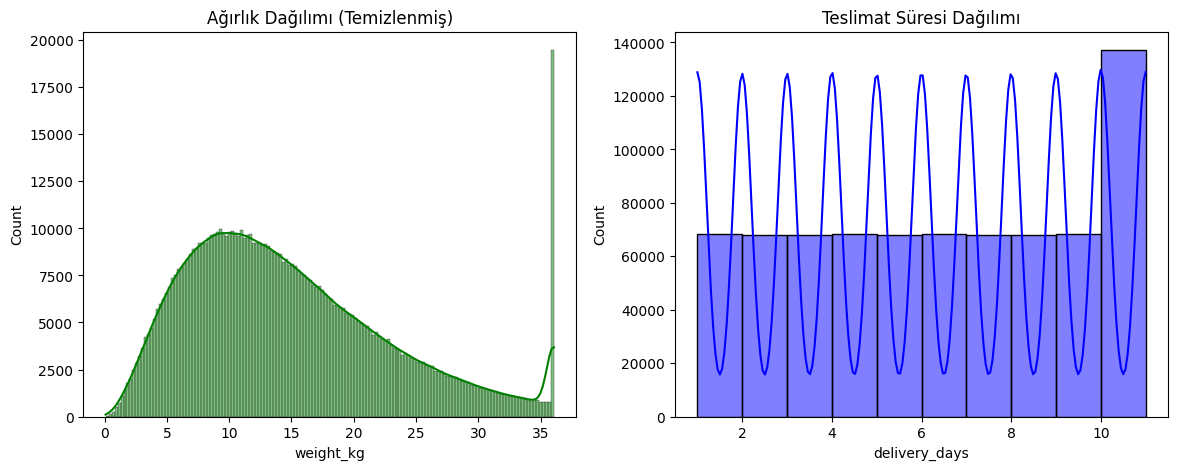

In [6]:
# Histogram (Veri Dağılımı)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['weight_kg'], kde=True, color='green')
plt.title('Ağırlık Dağılımı (Temizlenmiş)')

plt.subplot(1, 2, 2)
sns.histplot(df['delivery_days'], kde=True, color='blue', bins=10)
plt.title('Teslimat Süresi Dağılımı')

plt.show()

* Kodu çalıştırırken üstte oluşan uyarılar sonradan oluşabilecek hatalar ile ilgili bizi bilgilendirmekte, kısacası pandas ve seaborn kütüphaneleri arasında uyuşmazlık olabileceğinden bahsediyor.

### Grafik Yorumu

Elde edilen histogramlar ve KDE (Yoğunluk) eğrileri incelendiğinde alttaki bilgiler çıkarılmıştır:

**1. Ağırlık Dağılımı (Weight_kg):**
* **Yapı:** Veri seti genelinde ağırlıklar belirli bir aralığa (yaklaşık 0-30 kg arası) eşit bir şekilde yayılmıştır. Direkt tam belirgin bir normal dağılım görülmemektedir.
* **Yapılan İşlemlerin Etkisi:** Outlier işlemi uygulandığı için grafiğin sağ tarafında veriyi bozan uç değerler görülmemektedir. Böylece analizler daha düzgün olmuştur.
* **Kuyruk Analizi:** Grafiğin en sağındaki uzun çizgi verinin sağa çarpık olduğunu ve yüksek ağırlıklı gönderilerin azalarak devam ettiğini gösterir.

**2. Teslimat Süresi (Delivery_days):**
* **Yapı:** Teslimat süreleri genellikle 2 ile 10 gün arasında olmaktadır.
* **Dağılım:** Veri sağa veya sola yaslı değildir. Bu lojistik işlerinin sürelerinin tahmin edilebilir bir durumda olduğunu gösterir.
* **Kuyruk Analizi:** Grafiğin en sağındaki çizgi verinin yoğunluk tahmininden kaynaklanan matematiksel bir yumuşatma etkisidir.

# 1.7 Feature Engineering Adımları
---

Bu adım orijinal veriden farklı veriler üreterek daha iyi analizler yapmamızı sağlayan yönteme denir.

### Türetilen Yeni Değişkenler:
1.  Yoğunluk ($kg/m^3$):
    * Formül: $\frac{Weight}{Volume}$
    * Amacı: Yükün analizi için bir detay katacaktır.

2.  Risk Skoru (Risk Score):
    * Formül: $Delivery Days \times Weight$
    * Amacı: Yük ne kadar ağırsa ve taşınırken ne kadar çok taşınırsa riskler (hasar vs.) artar. Bunu gösteren tahmini bir değişken ürettik.

### Kategorik Dönüşüm (Encoding):
* One-Hot Encoding: `transport_mode` (AIR, SEA, ROAD) gibi nominal (sıralı olmayan) değişkenler, matematiksel modele uygun olması için 0 veya 1 ifadelerine dönüştürülmüştür.

In [7]:
# Yoğunluk Hesabı: Ağırlık / Hacim
df['density_kg_m3'] = df['weight_kg'] / df['volume_m3']

# Risk Skoru: Teslimat süresi x Ağırlık
df['risk_score'] = df['delivery_days'] * df['weight_kg']

# Transport Mode (AIR, SEA, ROAD değerlerini içeriyor) sütununu sayısal hale getiriyoruz
df_encoded = pd.get_dummies(df, columns=['transport_mode'], prefix='mode', drop_first=False)

# Dönüşümler sonrası veriyi gösteriyoruz
print("Feature Engineering Sonrası İlk 5 Satır:")
display(df_encoded[['shipment_id', 'density_kg_m3', 'risk_score', 'mode_AIR', 'mode_ROAD', 'mode_SEA']].head())

Feature Engineering Sonrası İlk 5 Satır:


,shipment_id,density_kg_m3,risk_score,mode_AIR,mode_ROAD,mode_SEA
0,S000000000,8.478261,40.95,False,True,False
1,S000000001,15.201117,136.05,True,False,False
2,S000000002,22.154639,193.41,False,False,True
3,S000000003,1.431262,11.40,True,False,False
4,S000000004,89.733333,80.76,False,False,True


# 1.8 Benzeri Veri Hazırlama Uygulamaları
---

### Düzeltme Adımı (Sonsuz Değer Verenler):
`Yoğunluk` hesabını yaparken (Ağırlık / 0) kaynaklanan sonsuz değerler olacaktır ve sistemin hata vermemesi için oluşan değerler ilgili sütunun ortalamasıyla değiştirilmiştir.

### Uygulanan Teknikler:
1.  Özellik Ölçeklendirme (MinMax Scaling): Değişkenler 0-1 aralığına sıkıştırılmıştır.
2.  Gruplandırma: Ağırlık değişkeni "Hafif", "Orta", "Ağır" olarak kategorize edilmiştir.

Veri içindeki sonsuz değerler temizlendi.

Ölçeklendirme İşlemi Tamamlandı (0-1 Arası).

Ölçeklendirme Öncesi ve Sonrası İstatistikler
ÖNCESİ (Ham Veri):


,min,max,mean,std
weight_kg,0.08000,36.065,14.833570,8.129675
volume_m3,0.00000,2.655,0.981428,0.647331
delivery_days,1.00000,11.000,6.004669,3.164866
density_kg_m3,0.06403,3606.500,29.511998,61.353892
risk_score,0.16000,396.715,89.077641,72.450957



SONRASI (MinMax Scaled - 0 ile 1 Arası):


,min,max,mean,std
weight_kg,0.0,1.0,0.409992,0.225918
volume_m3,0.0,1.0,0.369653,0.243816
delivery_days,0.0,1.0,0.500467,0.316487
density_kg_m3,0.0,1.0,0.008165,0.017012
risk_score,0.0,1.0,0.224225,0.182701



Gruplandırma İşlemi Tamamlandı.
   weight_kg  weight_segment
0       5.85  Hafif (0-10kg)
1      27.21    Ağır (20kg+)
2      21.49    Ağır (20kg+)
3       3.80  Hafif (0-10kg)
4      26.92    Ağır (20kg+)


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


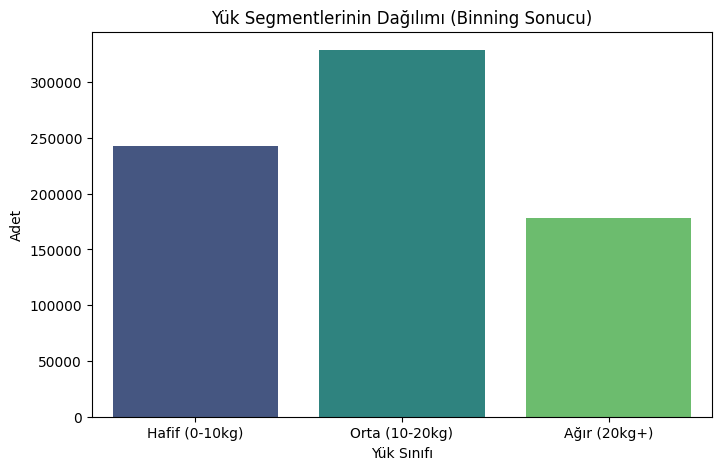

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Volume 0 olduğunda Density sonsuz çıkacağından bunu düzeltiyoruz

# Sonsuz değerleri NaN (Boş) yapıyoruz
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN olan yerleri sütunun ortalaması ile doldur
# Sadece sayısal sütunları seçip doldurma yapıyoruz
num_cols = df_encoded.select_dtypes(include=['number']).columns
df_encoded[num_cols] = df_encoded[num_cols].fillna(df_encoded[num_cols].mean())

print("Veri içindeki sonsuz değerler temizlendi.\n")

# Scaling İşlemleri
cols_to_scale = ['weight_kg', 'volume_m3', 'delivery_days', 'density_kg_m3', 'risk_score']

# Orijinal veriyi bozmamak için kopyasını alalım
df_scaled = df_encoded.copy()

scaler = MinMaxScaler()
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

print("Ölçeklendirme İşlemi Tamamlandı (0-1 Arası).")

# Bu tablo, verilerin ölçekleme öncesi ve sonrası dağılımını (min, max, ortalama) yan yana gösterir.
print("\nÖlçeklendirme Öncesi ve Sonrası İstatistikler")
print("ÖNCESİ (Ham Veri):")
display(df_encoded[cols_to_scale].describe().T[['min', 'max', 'mean', 'std']])

print("\nSONRASI (MinMax Scaled - 0 ile 1 Arası):")
display(df_scaled[cols_to_scale].describe().T[['min', 'max', 'mean', 'std']])

# Gruplandırma İşlemleri
# Ağırlığı kategorilere ayıralım: 0-10kg: Hafif, 10-20kg: Orta, 20+kg: Ağır
labels = ['Hafif (0-10kg)', 'Orta (10-20kg)', 'Ağır (20kg+)']
bins = [0, 10, 20, float('inf')]

df_encoded['weight_segment'] = pd.cut(df_encoded['weight_kg'], bins=bins, labels=labels)

print("\nGruplandırma İşlemi Tamamlandı.")
print(df_encoded[['weight_kg', 'weight_segment']].head())

# Sonuçları gösterelim
plt.figure(figsize=(8, 5))
sns.countplot(x='weight_segment', data=df_encoded, palette='viridis')
plt.title('Yük Segmentlerinin Dağılımı (Binning Sonucu)')
plt.xlabel('Yük Sınıfı')
plt.ylabel('Adet')
plt.show()